<a href="https://colab.research.google.com/github/AsherReedy/Monte-Carlo-iRisk-Lab-Meetings-and-Homework/blob/main/IRisk_Meeting03_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IRisk — Meeting 3
### Using Normal Draws in Simulation: Independence vs Correlation, and a 2007-style Loss Scenario

**Goals**
- Generate normals two ways (inverse transform and Box–Muller) and validate with the probability integral transform.
- Understand how adding independent normals behaves, and why dividing normals can be risky (heavy tails).
- Build a Monte Carlo of portfolio loan losses using independent normals, then allow correlation and compare tail risk (VaR/ES).


> **Parameters** — edit then run from top to bottom.

In [106]:
import math, time
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.grid'] = True

SEED = 121094
rng  = np.random.default_rng(SEED)
print("Seed:", SEED)

# Portfolio / scenario settings for the loss simulation
V0     = 1_000_000.0   # total notional
wA,wB  = 0.6, 0.4      # weights of two pools
muA,muB = 0.02, 0.03   # mean loss rates
sA,sB   = 0.020, 0.025 # vol of loss rates
alpha    = 0.99        # VaR/ES level
N        = 100_000     # Monte Carlo paths
threshold = 0.06*V0    # tail-loss threshold to compare

print(f"V0=${V0:,.0f} | weights A,B=({wA},{wB}) | means=({muA},{muB}) | sds=({sA},{sB}) | N={N:,} | alpha={alpha}")


Seed: 121094
V0=$1,000,000 | weights A,B=(0.6,0.4) | means=(0.02,0.03) | sds=(0.02,0.025) | N=100,000 | alpha=0.99


---
## A) Uniforms, Normals, and the Probability Integral Transform

- **Inverse transform sampling:** if $U\sim\text{Uniform}(0,1)$, then $Z=\Phi^{-1}(U)$ is $N(0,1)$.
- **Probability integral transform:** if $Z\sim N(0,1)$, then $U=\Phi(Z)$ is Uniform$(0,1)$.
We’ll implement both and do quick histogram checks.

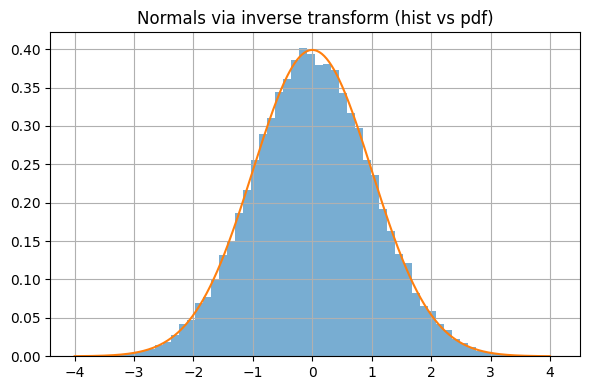

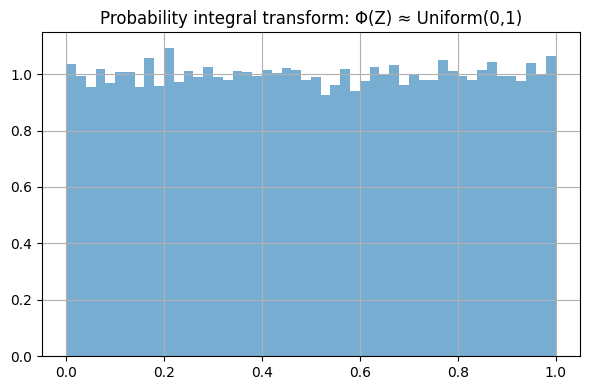

In [107]:
# From scratch, using Acklam approximations
def norm_cdf(z):
    return 0.5*(1.0 + math.erf(z/math.sqrt(2.0)))

def norm_ppf(p):
    a=[-3.969683028665376e+01, 2.209460984245205e+02,-2.759285104469687e+02,
       1.383577518672690e+02,-3.066479806614716e+01, 2.506628277459239e+00]
    b=[-5.447609879822406e+01, 1.615858368580409e+02,-1.556989798598866e+02,
       6.680131188771972e+01,-1.328068155288572e+01]
    c=[-7.784894002430293e-03,-3.223964580411365e-01,-2.400758277161838e+00,
       -2.549732539343734e+00, 4.374664141464968e+00, 2.938163982698783e+00]
    d=[ 7.784695709041462e-03, 3.224671290700398e-01, 2.445134137142996e+00,
        3.754408661907416e+00]
    plow=0.02425; phigh=1-plow
    if not (0 < p < 1):
        raise ValueError("p in (0,1)")
    if p < plow:
        q=math.sqrt(-2*math.log(p))
        return (((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5]) /                ((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+1)
    if p > phigh:
        q=math.sqrt(-2*math.log(1-p))
        return -(((((c[0]*q+c[1])*q+c[2])*q+c[3])*q+c[4])*q+c[5]) /                  ((((d[0]*q+d[1])*q+d[2])*q+d[3])*q+1)
    q=p-0.5; r=q*q
    return (((((a[0]*r+a[1])*r+a[2])*r+a[3])*r+a[4])*r+a[5])*q /            (((((b[0]*r+b[1])*r+b[2])*r+b[3])*r+b[4])*r+1)

def normals_via_inverse(n, rng):
    u = rng.random(n)
    return np.array([norm_ppf(ui) for ui in u])

Z = normals_via_inverse(60_000, rng)
U = np.array([norm_cdf(z) for z in Z])

plt.figure(); plt.hist(Z, bins=60, density=True, alpha=0.6)
x = np.linspace(-4,4,401); plt.plot(x, 1/np.sqrt(2*np.pi)*np.exp(-x**2/2))
plt.title("Normals via inverse transform (hist vs pdf)"); plt.tight_layout(); plt.show()

plt.figure(); plt.hist(U, bins=50, density=True, alpha=0.6)
plt.title("Probability integral transform: Φ(Z) ≈ Uniform(0,1)"); plt.tight_layout(); plt.show()

When you create simulations, you can save space by using the norm function in scipy or random.normal in numpy.

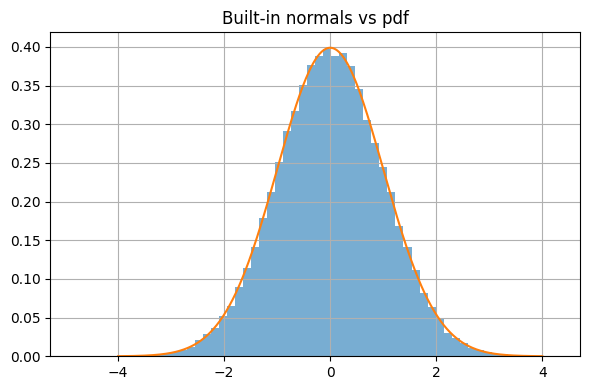

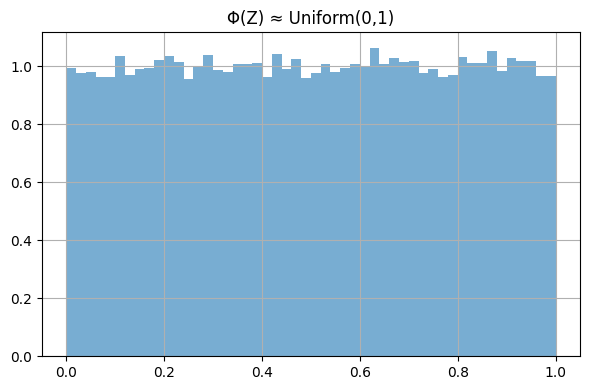

In [108]:
#More condensed version
from scipy.stats import norm

Z = rng.standard_normal(60_000)        # built-in normals
U = norm.cdf(Z)                        # Φ(Z)

plt.figure(); plt.hist(Z, bins=60, density=True, alpha=0.6)
x = np.linspace(-4,4,401); plt.plot(x, (1/np.sqrt(2*np.pi))*np.exp(-x**2/2))
plt.title("Built-in normals vs pdf"); plt.tight_layout(); plt.show()

plt.figure(); plt.hist(U, bins=50, density=True, alpha=0.6)
plt.title("Φ(Z) ≈ Uniform(0,1)"); plt.tight_layout(); plt.show()

---
## B) Adding and Dividing Independent Normals

- **Adding:** If $X\sim N(\mu_1,\sigma_1^2)$ and $Y\sim N(\mu_2,\sigma_2^2)$ are independent, then $X+Y\sim N(\mu_1+\mu_2,\sigma_1^2+\sigma_2^2)$.
- **Dividing:** If $X,Y\overset{iid}{\sim}N(0,1)$, then $X/Y$ is Cauchy (heavy tails). In Monte Carlo, avoid ratios with noisy denominators.

Sum mean≈0.397 (theory 0.400), var≈2.087 (theory 2.080)


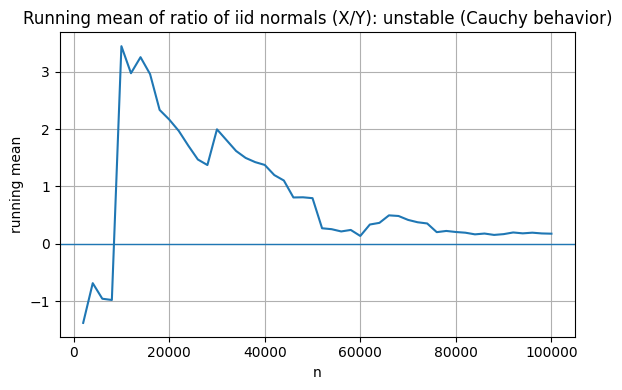

In [109]:
n = 100_000
X = normals_via_inverse(n, rng)*1.2 + 0.5   # N(0.5, 1.2^2)
Y = normals_via_inverse(n, rng)*0.8 - 0.1   # N(-0.1, 0.8^2)
S = X + Y

print(f"Sum mean≈{S.mean():.3f} (theory {0.5-0.1:.3f}), var≈{S.var(ddof=1):.3f} (theory {1.2**2+0.8**2:.3f})")

Z1 = normals_via_inverse(n, rng); Z2 = normals_via_inverse(n, rng)
R  = Z1 / Z2
k = 2000
idx = np.arange(k, n+1, k)
run_means = [np.mean(R[:m]) for m in idx]
plt.figure(); plt.plot(idx, run_means); plt.axhline(0, linewidth=1)
plt.title("Running mean of ratio of iid normals (X/Y): unstable (Cauchy behavior)")
plt.xlabel("n"); plt.ylabel("running mean"); plt.tight_layout(); plt.show()

---
## C) Monte Carlo: Loan Losses — Independence vs Correlation

Two pools A and B with loss rates $L_A, L_B$. Clip rates to $[0,1]$ to avoid negatives or >100%.
We compare independence vs correlated normals (correlation $\rho$ via Cholesky).

Independent: VaR@0.99=$60,640, ES=$65,656,  P(L>threshold)=1.103%
 Correlated (rho=0.50): VaR@0.99=$68,268, ES=$74,521,  P(L>threshold)=2.876%


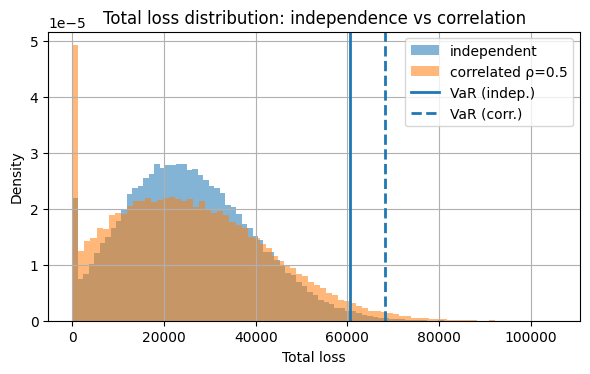

In [110]:
def clip01(x): return np.minimum(1.0, np.maximum(0.0, x))

def simulate_independent_losses(N, rng, V0, wA,wB, muA,muB, sA,sB):
    ZA = normals_via_inverse(N, rng); ZB = normals_via_inverse(N, rng)
    LA = clip01(muA + sA*ZA); LB = clip01(muB + sB*ZB)
    L  = V0*(wA*LA + wB*LB); return L, LA, LB

def simulate_correlated_losses(N, rng, V0, wA,wB, muA,muB, sA,sB, rho):
    Lchol = np.array([[1.0, 0.0],[rho, math.sqrt(1-rho**2)]]) #Cholesky Corr
    Z = normals_via_inverse(2*N, rng).reshape(2, N)
    ZA, ZB = (Lchol @ Z)
    LA = clip01(muA + sA*ZA); LB = clip01(muB + sB*ZB)
    L  = V0*(wA*LA + wB*LB); return L, LA, LB

def var_es(sample, alpha):
    q = np.quantile(sample, alpha)
    es = sample[sample >= q].mean()
    return float(q), float(es)

L_ind, LAi, LBi = simulate_independent_losses(N, rng, V0, wA,wB, muA,muB, sA,sB)
VaR_ind, ES_ind = var_es(L_ind, alpha)

rho = .5
# negative correlation is good for choosing assets bc they reduce the overall variance..

L_cor, LAc, LBc = simulate_correlated_losses(N, rng, V0, wA,wB, muA,muB, sA,sB, rho)
VaR_cor, ES_cor = var_es(L_cor, alpha)

print(f"Independent: VaR@{alpha:.2f}=${VaR_ind:,.0f}, ES=${ES_ind:,.0f},  P(L>threshold)={np.mean(L_ind>threshold):.3%}")

print(f" Correlated (rho={rho:.2f}): VaR@{alpha:.2f}=${VaR_cor:,.0f}, ES=${ES_cor:,.0f},  P(L>threshold)={np.mean(L_cor>threshold):.3%}")

plt.figure()
plt.hist(L_ind, bins=80, alpha=0.55, density=True, label="independent")
plt.hist(L_cor, bins=80, alpha=0.55, density=True, label=f"correlated ρ={rho}")
plt.axvline(VaR_ind, linewidth=2, label="VaR (indep.)")
plt.axvline(VaR_cor, linewidth=2, linestyle="--", label="VaR (corr.)")
plt.title("Total loss distribution: independence vs correlation")
plt.xlabel("Total loss"); plt.ylabel("Density"); plt.legend(); plt.tight_layout(); plt.show()

**Discussion:** Under independence, joint large losses are rare; correlation makes them more likely. This mirrors the 2007 story: models that treated pools/regions as nearly independent understated tail risk.

---
## Homework 3 Part 1


### Q1. Sensitivity to correlation
For $\rho\in\{0,0.2,0.4,0.6,0.8\}$, run the correlated-loss simulation and record VaR, ES, and $\mathbb P(L>\text{threshold})$. What pattern do you observe?

**Explanations:**
<font color="#00FFFF">  
As the correlation between the random variables increases, the VaR, ES, and probability of a loss greater than the threshold increase. The the formula for a portfolio's variance is: portfolio variance = w1var1 + w2var2 + 2w1w2sd1sd2 * rho. If rho is greater, the total variance of the portfolio will be larger which will result in a wider spread of the data and greater values for VaR, ES, and P(L > threshold).

In [111]:
# Your code for Q1
import pandas as pd

rhos = [0, 0.2, 0.4, 0.6, 0.8]
results = []

for rho in rhos:
  L_cor, LAc, LBc = simulate_correlated_losses(N, rng, V0, wA,wB, muA,muB, sA,sB, rho)
  VaR_cor, ES_cor = var_es(L_cor, alpha)
  L_threshold = np.mean(L_cor>threshold)

  results.append([rho, VaR_cor, ES_cor, L_threshold])

arr = np.array(results)
df = pd.DataFrame(arr, columns=['rho', 'VaR', 'ES', 'P(L>threshold)'])
df




,rho,VaR,ES,P(L>threshold)
0,0.0,60116.204580,65642.206358,0.01014
1,0.2,63707.946657,69544.071566,0.01790
2,0.4,67067.888151,73310.171927,0.02591
3,0.6,69578.476018,76232.117655,0.03346
4,0.8,72856.923957,79909.254766,0.04218


### Q2. Creating correlations
Explain how the Cholesky method turns independent normals into correlated normals.

 **Explanations:**
<font color="#00FFFF">  
If we have independent normals Z~N(0,Id) and a covariance matrix Σ, we want to blend the two together to create correlated normals.

Cholesky decomposition says that Σ = LL^T, where L is a lower-triangular matrix and A^T = A, covariance matricies have this symmetric property so we can use cholesky decomposition. Then we can define X = LZ, multiplying by L mixes the original normals to introduce covariance. We can show the covariance of X will equal Σ which achieves the goal of creating normal RVs X~N(0,Σ).
</font>

Cov(X) = LCov(Z)L^⊤ = LId​L^⊤ = LL^⊤ = Σ.



### Q3. Add a third pool
 Add a pool C with weight 0.2, mean 0.025, sd 0.02. Compare independence vs equal pairwise correlation $\rho=0.5$ for A,B,C. How do VaR and ES change?

 **Explanations:**
<font color="#00FFFF">  
 Between the independent and correlated simulations for the 3 pools, the correlated VaR and ES are much greater than the independent simulation. The positive correlation of .5 as well as the third correlated RV increased the total portfolio variance and raised the VaR and ES.

In [112]:
# Your code for Q3

rho = 0.5
wA, wB, wC  = 0.6, 0.4, .2      # weights of three pools
muA,muB,muC = 0.02, 0.03, .025      # mean loss rates
sA,sB,sC   = 0.020, 0.025, .02     # vol of loss rates


def simulate_independent_losses_three_pools(N, rng, V0, wA,wB,wC, muA,muB,muC, sA,sB,sC):
    ZA = normals_via_inverse(N, rng); ZB = normals_via_inverse(N, rng); ZC = normals_via_inverse(N, rng)
    LA = clip01(muA + sA*ZA); LB = clip01(muB + sB*ZB); LC = clip01(muC + sC*ZC)
    L  = V0*(wA*LA + wB*LB + wC*LC); return L, LA, LB, LC


def simulate_correlated_losses_three_pools(N, rng, V0, wA,wB,wC, muA,muB,muC, sA,sB,sC, rho):
    corr_matrix = np.array([
        [1.0, rho, rho],
        [rho, 1.0, rho],
        [rho, rho, 1.0]
    ])
    Lchol = np.linalg.cholesky(corr_matrix)
    Z = normals_via_inverse(3*N, rng).reshape(3, N)

    ZA, ZB, ZC = (Lchol @ Z)

    LA = clip01(muA + sA*ZA); LB = clip01(muB + sB*ZB); LC = clip01(muC + sC*ZC)
    L  = V0*(wA*LA + wB*LB + wC*LC); return L, LA, LB, LC

def var_es(sample, alpha):
    q = np.quantile(sample, alpha)
    es = sample[sample >= q].mean()
    return float(q), float(es)

L_ind, LAi, LBi, LCi = simulate_independent_losses_three_pools(N, rng, V0, wA,wB,wC, muA,muB,muC, sA,sB,sC)
VaR_ind, ES_ind = var_es(L_ind, alpha)

L_cor, LAc, LBc, LCc = simulate_correlated_losses_three_pools(N, rng, V0, wA,wB,wC, muA,muB,muC, sA,sB,sC, rho)
VaR_cor, ES_cor = var_es(L_cor, alpha)

print(f"Independent: VaR @ {alpha:.2f} = ${VaR_ind:,.0f}, ES = ${ES_ind:,.0f}")
print(f" Correlated (rho = {rho:.2f}): VaR @ {alpha:.2f} = ${VaR_cor:,.0f}, ES = ${ES_cor:,.0f}")

Independent: VaR @ 0.99 = $66,456, ES = $71,971
 Correlated (rho = 0.50): VaR @ 0.99 = $79,196, ES = $86,378


### Q4. Heavier tails
 Replace the normal drivers with $T_\nu$ (e.g., $\nu=5$) using $T=Z/\sqrt{(\chi^2_\nu/\nu)}$. Compare VaR/ES and $\mathbb P(L>\text{threshold})$ to the normal case. What changes and why?

 **Explanations:**
<font color="#00FFFF">  
 If both simulations have the same rho, the VaR, ES, and P(L>threshold) are much larger for the T driver simulation.

 VaR and ES are higher for the T drivers because placing more weight in the tails carries higher variance.
 </font>

 <font color="#00FFFF">  
 P(L>threshold) is larger because the T driver distribution has more weight in the tails. Fatter tails give the less likely results a bigger impact so the probability that a loss exceeds the threshold is higher.

In [113]:
# Your code for Q4

nu = 5
rho = .7

def t_drivers(N, d, rng, nu):
    """
    Generate d x N matrix of Student-t(ν) drivers.
    """
    # Standard normals
    Z = normals_via_inverse(d*N, rng).reshape(d, N)
    # Chi-square with ν dof
    chi2 = rng.chisquare(nu, size=N)
    # Broadcast denominator
    T = Z / np.sqrt(chi2 / nu)
    return T


def simulate_correlated_losses_three_pools_fat_tails(N, rng, V0, wA,wB,wC, muA,muB,muC, sA,sB,sC, rho, nu):
    corr_matrix = np.array([
        [1.0, rho, rho],
        [rho, 1.0, rho],
        [rho, rho, 1.0]
    ])
    Lchol = np.linalg.cholesky(corr_matrix)
    T = t_drivers(N, 3, rng, nu)

    ZA, ZB, ZC = (Lchol @ T)

    LA = clip01(muA + sA*ZA); LB = clip01(muB + sB*ZB); LC = clip01(muC + sC*ZC)
    L  = V0*(wA*LA + wB*LB + wC*LC); return L, LA, LB, LC

L_cor_T, LAc, LBc, LCc = simulate_correlated_losses_three_pools_fat_tails(N, rng, V0, wA,wB,wC, muA,muB,muC, sA,sB,sC, rho, nu)
VaR_cor_T, ES_cor_T = var_es(L_cor_T, alpha)
L_threshold_T = np.mean(L_cor_T>threshold)

L_cor, LAc, LBc, LCc = simulate_correlated_losses_three_pools(N, rng, V0, wA,wB,wC, muA,muB,muC, sA,sB,sC, rho)
VaR_cor, ES_cor = var_es(L_cor, alpha)
L_threshold = np.mean(L_cor>threshold)


print(f" Correlated Student T Drivers (rho = {rho:.2f}): VaR @ {alpha:.2f} = ${VaR_cor_T:,.0f}, ES = ${ES_cor_T:,.0f}, P(L>threshold)={np.mean(L_cor_T>threshold):.3%}")
print(f" Correlated Normal Drivers (rho={rho:.2f}): VaR@{alpha:.2f}=${VaR_cor:,.0f}, ES=${ES_cor:,.0f},  P(L>threshold)={np.mean(L_cor>threshold):.3%}")



 Correlated Student T Drivers (rho = 0.70): VaR @ 0.99 = $107,720, ES = $132,546, P(L>threshold)=12.223%
 Correlated Normal Drivers (rho=0.70): VaR@0.99=$83,786, ES=$92,065,  P(L>threshold)=9.369%
